<a href="https://colab.research.google.com/github/Satwikram/Deep-Learning-Implementations/blob/master/BERT/Quora%20Insincere%20Questions%20Classification%20using%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

**BERT**

### Importing Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.4.0'

### Install TensorFlow Model Garden

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2319/2319), done.
remote: Total 2650 (delta 511), reused 1351 (delta 298), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 30.88 MiB/s, done.
Resolving deltas: 100% (511/511), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



### Install requirements to use tensorflow/models repository

In [4]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 215kB 7.2MB/s 
     |████████████████████████████████| 296kB 9.2MB/s 
     |████████████████████████████████| 102kB 5.7MB/s 
     |████████████████████████████████| 25.9MB 128kB/s 
     |████████████████████████████████| 174kB 58.4MB/s 
     |████████████████████████████████| 3.6MB 59.4MB/s 
     |████████████████████████████████| 706kB 54.3MB/s 
     |████████████████████████████████| 358kB 44.5MB/s 
     |████████████████████████████████| 1.1MB 44.8MB/s 
     |████████████████████████████████| 11.6MB 47.3MB/s 
     |████████████████████████████████| 36.7MB 153kB/s 
     |████████████████████████████████| 276kB 59.1MB/s 
     |████████████████████████████████| 2.2MB 50.4MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
ERROR: pandas-gbq 0.13.3 has requirement google-cloud-bi

### Connecting to Kaggle

In [3]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading Quora Insincere Questions Dataset

In [5]:
!kaggle competitions download -c quora-insincere-questions-classification

 75% 41.0M/54.9M [00:01<00:00, 28.6MB/s]
100% 54.9M/54.9M [00:01<00:00, 39.2MB/s]
100% 5.94G/5.96G [01:26<00:00, 85.1MB/s]
100% 5.96G/5.96G [01:26<00:00, 73.7MB/s]
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 66.8MB/s]
 32% 5.00M/15.8M [00:00<00:00, 48.4MB/s]
100% 15.8M/15.8M [00:00<00:00, 77.2MB/s]


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [9]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.4.0
Eager mode:  True
Hub version:  0.10.0
GPU is NOT AVAILABLE


In [10]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [12]:
df = pd.read_csv('/content/train.csv')

In [13]:
df.shape

(1306122, 3)

In [14]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [16]:
df['target'].unique()

array([0, 1])

In [17]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

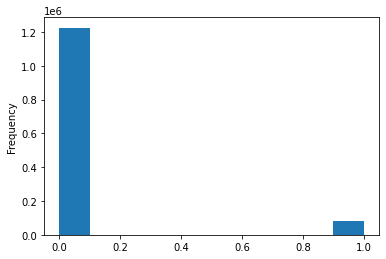

In [18]:
df['target'].plot(kind = 'hist')

### Splitting dataset and stratifying the unbalnced dataset

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
train_df, remaining = train_test_split(df, train_size = 0.0075, random_state = 42, stratify = df.target.values)

In [96]:
valid_df, _ = train_test_split(remaining, train_size = 0.00075, random_state = 42, stratify = remaining.target.values) 

In [97]:
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

### Create tf.dataset for training and evaluation

In [98]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


### Download Pre-Trained BERT Model from TensorFlow Hub

In [99]:
label_list = [0, 1]
max_seq_length = 128
batch_size = 32

In [100]:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

In [101]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable = True)

In [102]:
bert_layer

In [103]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [104]:
tokenizer.wordpiece_tokenizer.tokenize("hi, I am Satwik Ram !")

['hi', '##,', '[UNK]', 'am', '[UNK]', '[UNK]', '!']

In [105]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, I am Satwik Ram !"))

[7632, 29623, 100, 2572, 100, 100, 999]

### Tokenize and preprocess Text for BERT

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using classifier_data_lib's constructor InputExample provided in the BERT library.

In [106]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

### Wrap a python function into a TensorFlow op for a Eager Execution

In [107]:
def to_feature_map(text, label):

  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, 
                                                                 inp = [text, label],
                                                                 Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_words_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

### Create a tensorFlow input Pipeline with tf.data

In [108]:
with tf.device('/cpu:0'):

  train_data = (train_data.map(to_feature_map, 
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  valid_data = (valid_data.map(to_feature_map, 
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))


In [109]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [110]:
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

### Add a Classification Layer to the Bert Head

#### Build the model

In [111]:
def build_model():

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
  
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)

  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = "output")(drop)

  model = tf.keras.Model(
      inputs = {
          'input_words_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
          },

      outputs = output
    )
  
  return model

### Fine Tuning the BERT for Text Classification

In [112]:
model = build_model()

In [113]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

### Compiling the model

In [114]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.losses.BinaryCrossentropy()])

### Train the model

In [ ]:
history = model.fit(train_data, validation_data = valid_data, epochs = 10, verbose = 1)

Epoch 1/10
154/306 [==============>...............] - ETA: 1:40:40 - loss: 0.2575 - binary_crossentropy: 0.2575